# LinkedIn friends' network

## We begin by installing some packages that are not very common to have.
## Selenium is the web-scrapper, the one which will go page by page and collect the data we need. Networkx will create the nice graph with the connections. Python-louvain (which is called as 'community' in python) makes the distinction of the groups in the graph.

In [ ]:
pip install selenium
pip install networkx
pip install python-louvain

## Together with Selenium, one must also download a webdriver, that program will build the bridge from the python code and the (Chrome) browser.

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import numpy as np
import networkx as nx

In [2]:
#Initialize the chromedriver with its location in your computer
driver = webdriver.Chrome('C:/Users/Victor/Downloads/chromedriver.exe')

In [3]:
#Open LinkedIn webpage
driver.get('https://www.linkedin.com')

In [4]:
#This will write your LinkedIn e-mail on the proper space in the page
username=driver.find_element_by_id('session_key')
username.send_keys('your@email.com')

In [5]:
#This will write your password
password=driver.find_element_by_id('session_password')
password.send_keys('your_linkedin_password')

In [6]:
#This clicks the button (one could do it manually, but it's not necessary)
login_button=driver.find_element_by_class_name('sign-in-form__submit-button')
login_button.click()

In [7]:
#Minimizes messages tab
driver.find_element_by_xpath('/html/body/div[5]/aside/div[1]/header/section[2]/button[2]').click()

In [8]:
#Going to 'My connections' webpage
driver.get('https://www.linkedin.com/mynetwork/invite-connect/connections/')

In [9]:
#Clicking on 'filtering options'
driver.find_element_by_class_name('mn-connections__search-with-filters.link-without-visited-state.ember-view').click()

In [10]:
#Finding the total number of connections from the page's header
conn=driver.find_element_by_class_name('pb2.t-black--light.t-14').text
total_connections=int(conn.split(' ', 1)[0])

#Since each page has 10 connections, this will calculate the number of pages to be scrapped and how many on a remaining page
total_pages=int(np.ceil(total_connections/10))
last_page=total_connections%10
print(total_connections)

238


## Collecting a list of all connections/friends (nodes)

In [11]:
#It goes all the way through the webpage and append each friend's link to 'friendlist'.
#In order to extract this link, the XPath of the link on the name of each user is taken.
#Since some pages on LinkedIn have a different XPath for where the link is, a try-function is used.

friendlist=[]
for j in range(total_pages-1):
    for i in range(10):
        try:
            path="/html/body/div[6]/div[3]/div/div[1]/div/div[1]/main/div/div/div[2]/ul/li["+str(i+1)+"]/div/div/div[2]/div[1]/div[1]/div/span[1]/span/a"
            friendlist.append(driver.find_element_by_xpath(path).get_attribute('href'))
        except:
            path="/html/body/div[5]/div[3]/div/div[1]/div/div[1]/main/div/div/div[2]/ul/li["+str(i+1)+"]/div/div/div[2]/div[1]/div[1]/div/span[1]/span/a"
            friendlist.append(driver.find_element_by_xpath(path).get_attribute('href'))
    next_page="https://www.linkedin.com/search/results/people/?network=%5B%22F%22%5D&origin=MEMBER_PROFILE_CANNED_SEARCH&page="+str(j+2)
    driver.get(next_page)

if last_page == 0:
    print('The full list of connections is done, with '+str(len(friendlist))+' connections.')
else:
    for i in range(last_page):
        try:
            path="/html/body/div[6]/div[3]/div/div[1]/div/div[1]/main/div/div/div[2]/ul/li["+str(i+1)+"]/div/div/div[2]/div[1]/div[1]/div/span[1]/span/a"
            friendlist.append(driver.find_element_by_xpath(path).get_attribute('href'))
        except:
            path="/html/body/div[5]/div[3]/div/div[1]/div/div[1]/main/div/div/div[2]/ul/li["+str(i+1)+"]/div/div/div[2]/div[1]/div[1]/div/span[1]/span/a"
            friendlist.append(driver.find_element_by_xpath(path).get_attribute('href'))
    print('The full list of connections is done, with '+str(len(friendlist))+' connections.')

The full list of connections is done, with 238 connections.


In [9]:
#I only need the relevant part of the links (like 'https://www.linkedin.com/in/vccalves/'), so anything beyond that is removed
def belo_nome(s):
    belo=str()
    for i in range(len(s)):
        if s[i]=="?":
            belo=belo+"/"
            break
        else:
            belo=belo+s[i]
    return belo

In [13]:
#Updating 'friendlist' with better links
fl=[]
for i in friendlist:
    fl.append(belo_nome(i))

In [14]:
#Since it may take some time and effort, it's useful to store the link's list

textfile = open('fl.txt', "w")
for element in fl:
    textfile.write(element + "\n")
textfile.close()

In [2]:
#If you have already stored it, here is how to open and read it
textfile = open('fl.txt', "r")

fl_lines=textfile.read()

fl=fl_lines.split()

## Collecting all common connections between you and your friends (edges)

In [27]:
#We will neglect all friends with no common connections.
#This for-loop creates a dictionaire, where the keys are the friends and the values are the common connections.
fmore=[]
edges={}
for link in fl:
    driver.get(link)
    try:
        driver.get(link)
        driver.find_element_by_class_name('app-aware-link.display-flex').click()
        fmore.append(link)
        contagem=WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'pb2.t-black--light.t-14')))
        cons=contagem.text
        total_cons=int(cons.split(' ', 1)[0])
        edges.update({link:[]})
        edges_da_vez=get_edges(str(link), total_cons)
        edges[link].extend(edges_da_vez)
    except:
        print(str(link)+" sem amigos em comum.")

In [12]:
#This scraps all connections from 1 friend (link), that has a total of common connections (total_cons)
def get_edges(link, total_cons):
    edges_local=[]
    total_pages=int(np.ceil(total_cons/10))
    last_page=total_cons-10*(total_pages-1)
    page_name=driver.current_url
    if total_cons <=10:
        con_round = total_cons
        edges_local.extend(get_links(link, con_round))
        return edges_local
    else:
        con_round=10
        for j in range(total_pages-1):
            edges_local.extend(get_links(link, con_round))
            next_page=page_name+"&page="+str(j+2)
            driver.get(next_page)
        edges_local.extend(get_links(link, last_page))
        return edges_local

In [ ]:
#This collects all the links from 1 page shown
def get_links(link, con_round):
    edges_local=[]
    for i in range(con_round):
        try:
            path="/html/body/div[6]/div[3]/div/div[1]/div/div[1]/main/div/div/div[2]/ul/li["+str(i+1)+"]/div/div/div[2]/div[1]/div[1]/div/span[1]/span/a"
            link_con=driver.find_element_by_xpath(path).get_attribute('href')
            linkb=belo_nome(link_con)
            edges_local.append(linkb)
        except:
            path="/html/body/div[5]/div[3]/div/div[1]/div/div[1]/main/div/div/div[2]/ul/li["+str(i+1)+"]/div/div/div[2]/div[1]/div[1]/div/span[1]/span/a"
            link_con=driver.find_element_by_xpath(path).get_attribute('href')
            linkb=belo_nome(link_con)
            edges_local.append(linkb)
    return edges_local

In [ ]:
# LinkedIn may kick your connection after about 400 accesses, if so,
#find the index of the first friend which this happened and just update the fl list:
fl2=[]
for i in range(begin,end,1):
    fl2.append(fl[i])
print(fl2)
#Now re-run the main for-loop above with fl2. Also put a # in front of 'fmore=[]' and 'edges={}', so the existing list isn't erased.

In [ ]:
#Add yourself as an edge, being a connection to everybody
edges.update({"YOU": fmore})

In [3]:
#A simple way to store a dictionaire is using pickle
import pickle

In [41]:
#After such effort and time, store the dictionaire in a external file
a_file = open("edges.pkl", "wb")
pickle.dump(edges, a_file)
a_file.close()

In [5]:
#If it was already stored in the past, restore it
a_file = open("edges.pkl", "rb")
edges = pickle.load(a_file)

## Drawing the network

In [4]:
import matplotlib.pyplot as plt

In [6]:
#In order to identify the connections, I kept only the consonants of their usernames, this is optional
def nm(s):
    consonants=list("qwrtypsdfghjklzxcvbnm")
    new=str()
    if s[0]=="h":
        for i in range(28,len(s),1):
            if s[i] in consonants:
                new+=s[i]
            else:
                None
    else:
        new=s
    return new

In [7]:
#Passing the edges dictionaire to a readable function for the networkx
edgesb=[]
for k, v in edges.items():
    for item in v:
        if item in edges.keys() or item in fl:
            edgesb.append((nm(k), nm(item)))

fmore=[nm(item) for item in edges.keys()]

In [8]:
#Initialize the graph
H=nx.Graph()

#Get the nodes from fmore
H.add_nodes_from(fmore)

#Get the edges from your edges
H.add_edges_from(edgesb)

posb = nx.spring_layout(H) # get the position using the spring layout algorithm

In [1]:
import community #This is how the python-louvain packed is called

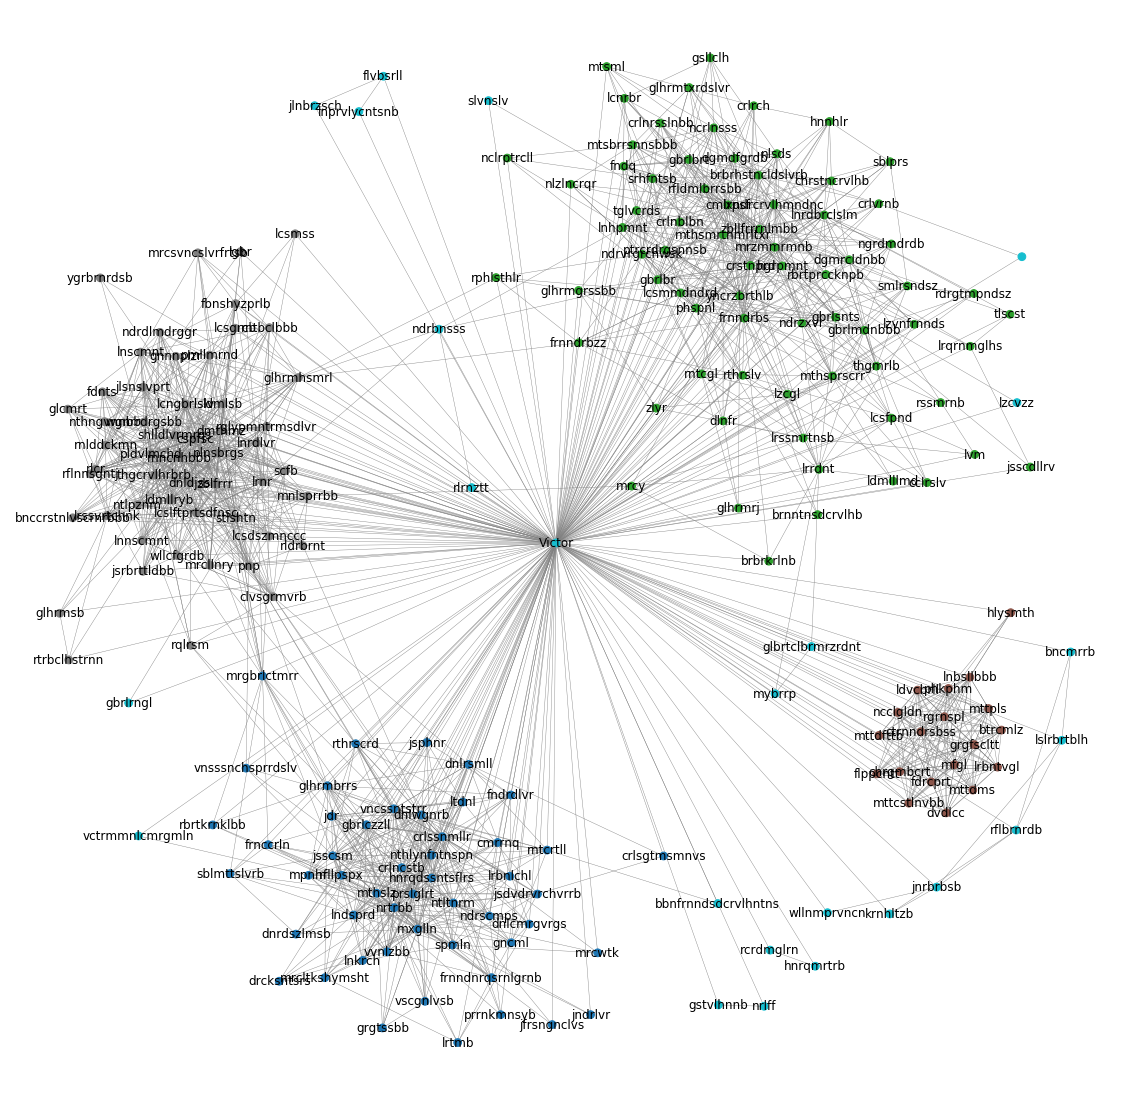

In [21]:
part = community.best_partition(H)
values = [part.get(node) for node in H.nodes()]

plt.rcParams['figure.figsize'] = [20, 20]
nx.draw_networkx(H, pos = posb, 
                 cmap = plt.get_cmap('tab10'), node_color = values,
                 node_size=60, width=0.4, edge_color='gray', with_labels=True)
#To get away with the names, set with_labels=False
limits=plt.axis('off')

In [ ]:
#happiness feeling